In [1]:
import numpy as np
import torch
import botorch
import gpytorch

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

from helper_functions.utils import *
from helper_functions.surrogate_model import *
from helper_functions.cost_model_regression import init_cost_model, get_best_system_params

%load_ext autoreload
%autoreload 2

torch.set_default_dtype(torch.float64) # avoid matrix not positive semi-definite

In [5]:
# Step 1: init points
train_x, train_y, best_y, train_y_cost = get_initial_data(10, ack, show_plot=False)

# Step 2a; init gp model and fit
single_model, mll = init_gp_model(train_x, train_y)
# Step 2b: init cost model and fit
cost_model, likelihood = init_cost_model(train_x, train_y_cost)

# Step 3: Init acq func
ei = init_acq_func(single_model, best_y)

# Step 4: Generate candidates
candidates_model_params = gen_candidates(1, ei)
candidates = get_best_system_params(cost_model, likelihood, candidates_model_params)

In [6]:
for i in range(100):
    cost_models = []
    
    # Step 1: Evaluate candidates
    model_evaluation = evaluate_f(candidates, ack)
    cost_evaluation = evaluate_cost(candidates)

    # update the master records
    train_x = torch.cat([train_x, candidates])
    train_y = torch.cat([train_y, model_evaluation])
    train_y_cost = torch.cat([train_y_cost, cost_evaluation])
    
    best_y = train_y.max()
    
    # Step 2a: Init Surrogate Model & fit
    single_model, mll = init_gp_model(train_x, train_y)
    # Step 2b: Init Cost Model & fit
    cost_model, likelihood = init_cost_model(train_x, train_y_cost)
    cost_models.append(cost_model)
    
    # Step 3: Init acq func
    ei = init_acq_func(single_model, best_y)
    
    # Step 4a: Acquire new candidate
    candidates_model_params = gen_candidates(1, ei)
    # Step 4b: Get best system parameters
    candidates = get_best_system_params(cost_model, likelihood, candidates_model_params)

    print(
        (
            f"#{i+1:3,} | "
            f"Best: {best_y} | \n"
            f"\tModel Params:  {from_n_unit_cube(candidates[0,:].unsqueeze(0))[:,:2]} \n"
            f"\tSystem Params: {from_n_unit_cube(candidates[0,:].unsqueeze(0))[:,2:]} \n"
            f"\tResult: Distance {model_evaluation[0,0]:,.02f} | \n\t\tCost {cost_evaluation[0]:,.02f} \n\n"
        ))

#  1 | Best: -1.001308154847262 | 
	Model Params:  tensor([[ 1.9430, -5.8227]]) 
	System Params: tensor([[ 2.,  2., 64.]]) 
	Result: Distance -1.00 | 
		Cost 59.32 


#  2 | Best: -1.001308154847262 | 
	Model Params:  tensor([[3.2775, 0.5068]]) 
	System Params: tensor([[ 2.,  2., 64.]]) 
	Result: Distance -3.61 | 
		Cost 59.81 


#  3 | Best: -1.001308154847262 | 
	Model Params:  tensor([[-1.1928,  4.2930]]) 
	System Params: tensor([[ 2.,  2., 64.]]) 
	Result: Distance -2.36 | 
		Cost 63.39 


#  4 | Best: -1.001308154847262 | 
	Model Params:  tensor([[-32.,  32.]]) 
	System Params: tensor([[ 2.,  2., 64.]]) 
	Result: Distance -3.02 | 
		Cost 55.00 


#  5 | Best: -1.001308154847262 | 
	Model Params:  tensor([[-11.7124,  -2.7221]]) 
	System Params: tensor([[ 2.,  2., 64.]]) 
	Result: Distance -10.81 | 
		Cost 31.46 


#  6 | Best: -1.001308154847262 | 
	Model Params:  tensor([[ 8.9876, -0.9984]]) 
	System Params: tensor([[ 2.,  2., 64.]]) 
	Result: Distance -4.66 | 
		Cost 37.68 


#  

In [4]:
print(from_n_unit_cube(train_x))

tensor([[ 2.2957e+00, -5.6887e+00,  2.3651e+01,  9.7633e+00,  1.0266e+01],
        [ 2.9545e+01, -1.8674e+01,  2.0310e+01,  5.2203e+00,  5.9793e+00],
        [-2.4719e+01, -8.3172e+00,  8.7540e+00,  2.6972e+00,  4.3961e+00],
        [-1.5952e+01,  2.7079e+01,  1.2150e+01,  2.6013e+00,  9.4237e+00],
        [ 6.8133e+00,  2.5702e+01,  2.7985e+01,  9.8147e+00,  6.2420e+00],
        [ 1.7850e+00,  5.9175e+00,  2.8305e+01,  8.1224e+00,  6.9354e+00],
        [-9.0844e+00,  3.0082e+01,  8.0179e+00,  3.0731e+00,  4.1253e+01],
        [ 2.2402e+01, -2.9663e+00,  1.0625e+01,  3.5703e+00,  8.8468e+00],
        [ 2.7577e+01,  1.0502e+01,  2.1018e+00,  2.8547e+00,  1.7906e+01],
        [ 1.4175e+01, -1.7359e+01,  1.0861e+01,  3.8858e+00,  4.5494e+00],
        [ 9.5267e-01, -1.5074e+01,  2.2000e+01,  1.0000e+01,  1.6000e+01],
        [ 2.0110e+00,  1.7965e+01,  2.1000e+01,  1.0000e+01,  3.2000e+01],
        [ 1.9930e+00,  5.2789e-01,  2.1000e+01,  1.0000e+01,  3.2000e+01],
        [ 3.0506e+00,  1.

We can choose every configuration, not just a random

- not cost aware vs cost aware
- cost aware (our solution) vs cost aware (guinet/pareto)
- look for papers that chose system paretmaetrs since guinet isnt compatible for comparisons
- run guint for different system arameters (static) to compare cost with our

- keep n_init high to populate the cost model well
- if iterating too fast, make cost model too steep to see the difference

Plotting the posterior distribution

In [5]:
x = np.linspace(0,1,10)
y = np.linspace(0,1,10)
x_mesh, y_mesh = np.meshgrid(x,y)
x_mesh_denormalized = from_unit_cube(x_mesh, variable_type = "phi")
y_mesh_denormalized = from_unit_cube(y_mesh, variable_type = "chi")


mean_train_x = single_model.posterior(train_x[:,:2]).mean.detach().numpy()

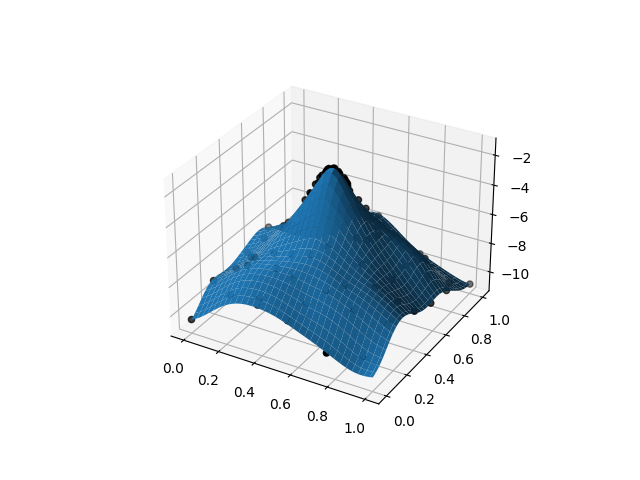

In [6]:
# posterior distribution plot
fig = plt.figure()

# plot the candidate points
ax = fig.add_subplot(projection='3d')
ax.scatter3D(train_x[:,0], train_x[:,1], mean_train_x.squeeze(), color="black")

# plot the posterior distribution
x = np.linspace(0,1,64)
y = np.linspace(0,1,64)
x_mesh, y_mesh = np.meshgrid(x,y)

# convert x_mesh, y_mesh into x,y pairs because 
# that is how mean function is sampled from the posterior distribution
mean_compatibale_coordinates = torch.tensor(  np.stack((x_mesh, y_mesh), axis=-1).reshape((4096,2))  )
mean = single_model.posterior(mean_compatibale_coordinates).mean.detach().numpy()
# convert the extracted mean values back into the plot surface compatible format
mean_mesh = mean.reshape((64,64))

ax.plot_surface(x_mesh, y_mesh, mean_mesh)

# plot the ackley function
# ax.plot_surface(x_mesh, y_mesh, ack(from_unit_cube(x_mesh), from_unit_cube(y_mesh)), color="yellow", alpha=0.2)

In [7]:
torch.column_stack([from_unit_cube(train_x[:,2], variable_type = "nnodes"),
from_unit_cube(train_x[:,3], variable_type = "ntasks"),
from_unit_cube(train_x[:,4], variabx = np.linspace(-32,32,100)
    y = np.linspace(-32,32,100)x = np.linspace(0,1,64)
y = np.linspace(0,1,64)
x_mesh, y_mesh = np.meshgrid(x,y)

    x_ids, y_ids = np.meshgrid(x,y)le_type = "mem")])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2375229765.py, line 3)

In [ ]:
print(f"#{i+1:3,} | \
            Best: {best_y} | \
            ({from_unit_cube(candidates[0,0], variable_type = "phi"):6,.02f}, \
             {from_unit_cube(candidates[0,1], variable_type = "chi"):6,.02f}) => {model_evaluation[0,0]:,.02f}")